# 基于分布的生存分析

上文我们采用Kaplan-Meier 模型进行生存分析，我们注意到当数据出现删失的情况下，生存曲线出现了神转折。

我们是否可以按照之前的曲线的“趋势”，近似的修正这个转折曲线呢？

这个时候我们就需要考虑带有参数的拟合。

首先我们将之前的写好的函数复制过来。

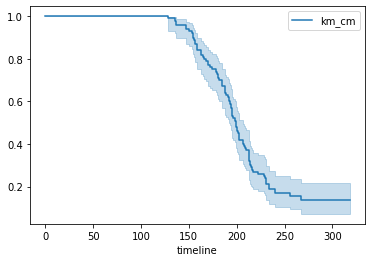

In [1]:
import pandas as pd
# read training data 
train_df = pd.read_csv('../data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['observed'] = (train_df['cycle'] >= train_df['max'])

import lifelines
from matplotlib import pyplot as plt
max_event = train_df.groupby('id').last()
max_event_censor_1 = train_df[train_df['max']<=250].groupby('id').last()  
max_event_censor_2 = train_df[(train_df['max']>250) & (train_df['cycle']>250)].groupby('id').sample(n=1,random_state=21)

max_event_censor_mix = pd.concat([max_event_censor_1,max_event_censor_2])
kmf_cm = lifelines.KaplanMeierFitter(label='km_cm')
kmf_cm.fit(durations=max_event_censor_mix['cycle'],
event_observed=max_event_censor_mix['observed'])
kmf_cm.plot_survival_function()
plt.show()

<AxesSubplot:>

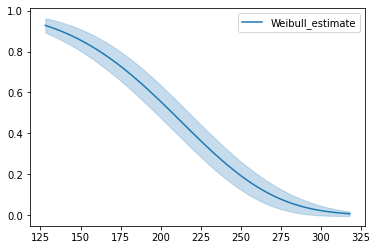

In [2]:
from lifelines import WeibullFitter
wb = WeibullFitter()
wb.fit(durations=max_event_censor_mix['cycle'],
event_observed=max_event_censor_mix['observed'])
wb.plot_survival_function()

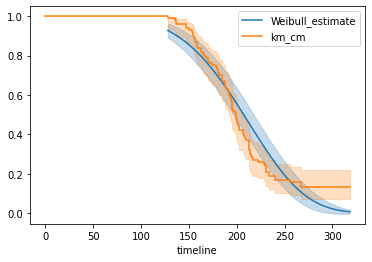

In [3]:
ax = wb.plot_survival_function()
kmf_cm.plot_survival_function(ax=ax)
plt.show()

## 韦布尔分布
Weibull随机变量的概率密度函数为：

![image.png](../img/w1.png)

其中k > 0 是形状参数，λ > 0 是分布的尺度参数。K有时也用rho表示。

通俗的讲，在没有协变量的情况下，λ(尺度) 参数有一个适用的解释：它代表63.21%的研究对象发生事件的时间。这ρ（rho形状）参数控制累积危险是凸的还是凹的，代表加速或减速的危险。（lifeline)

lambda_ 表示尺度scale， rho_表示shape 形状。

- 当rho_>1时，失效率随时间增长。

- 当rho_= 1时，失效率不变。Weibull 分布简化为指数分布,可能表明随机的外部事件正在导致失效。

- 当rho_< 1时，失效率随时间递减。


In [4]:
print(wb.lambda_)
print(wb.rho_)

224.46081059532617
4.610756589138583


## 比较不同工况（回归模型）
加速失效时间模型（AFT 模型）是一种参数模型,，我们前面提到当rho_ 控制失效发生的速度。

我们试想，有一些外部变量，他们起的作用就是让失效加速和或者减速发生。

假设我们有两组研究对象 A 和 B，具有不同的生存函数，不同的生存函数与一些加速故障率有关：

\begin{split}S_A(t) = S_B\left(\frac{t}{\lambda(x)}\right)\\
\lambda(x) = \exp\left(b_0 + \sum_{i=1}^n b_i x_i \right)\end{split}

一个典型的例子是狗的衰老速度是人类的 7 倍，即λ=1/7。

这个λ 可以用协变量的函数表示，如上图。

该模型可以根据受试者的协变量加速或减速失败时间。另一个很好的特点是易于解释系数：单位增加xi意味着平均/中位生存时间的变化因子为exp(bi).

In [5]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
aft.fit(df=max_event_censor_mix[['setting1','setting2','setting3','cycle','observed']],duration_col='cycle',
event_col='observed')
aft.summary

c:\users\renb\pycharmprojects\survival_analysis\env\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in expm1
  return f_raw(*args, **kwargs)
c:\users\renb\pycharmprojects\survival_analysis\env\lib\site-packages\autograd\numpy\numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
c:\users\renb\pycharmprojects\survival_analysis\env\lib\site-packages\lifelines\utils\safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans


coef     exp(coef)      se(coef)  coef lower 95%  \
param   covariate                                                          
lambda_ setting1   14.264596  1.566879e+06  1.030299e+01   -5.928889e+00   
        setting2  -63.361847  3.035983e-28  8.001260e+01   -2.201837e+02   
        setting3    0.054626  1.056146e+00  1.210791e+04   -2.373102e+04   
        Intercept  -0.053591  9.478199e-01  1.210791e+06   -2.373107e+06   
rho_    Intercept   1.549135  4.707399e+00  8.462442e-02    1.383275e+00   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ setting1     3.445808e+01         2.661438e-03         9.224748e+14   
        setting2     9.345996e+01         2.373850e-96         3.882803e+40   
        setting3     2.373113e+04         0.000000e+00                  inf   
        Intercept    2.373107e+06         0.000000e+00                  inf   
rho_    Intercept    1.714996e+00         3.987939e+00         5.556655e+00   

                              z             p      -log2(p)  
param   covariate                                            
lambda_ setting1   1.384511e+00  1.662022e-01  2.588989e+00  
        setting2  -7.918984e-01  4.284199e-01  1.222903e+00  
        setting3   4.511629e-06  9.999964e-01  5.193364e-06  
        Intercept -4.426093e-08  1.000000e+00  5.094894e-08  
rho_    Intercept  1.830601e+01  7.410636e-75  2.462550e+02

In [6]:
aft.median_survival_time_

208.59217014727494

关于解释的重要说明：（lifeline）

假设coef为正，则因子exp(coef)大于 1，这将延缓、或者减慢事件发生的事件，因为我们将时间除以该因子，这会增加生存期的平均值。

相反的，coef为负时，将加快事件时间发生，也就是减少生存期的平均值。


In [7]:
max_event_censor_mix[['setting1','setting2','setting3','cycle','observed']].describe()

,setting1,setting2,setting3,cycle
count,100.000000,100.000000,100.0,100.000000
mean,0.000073,-0.000050,100.0,203.000000
std,0.002272,0.000289,0.0,39.440788
min,-0.004900,-0.000500,100.0,128.000000
25%,-0.001450,-0.000300,100.0,177.000000
50%,0.000200,-0.000100,100.0,199.000000
75%,0.001400,0.000200,100.0,229.250000
max,0.007700,0.000600,100.0,318.000000


In [8]:
max_event_censor_mix['setting1'].quantile([0.1, 0.5,0.9]).values

array([-0.00281,  0.0002 ,  0.0026 ])

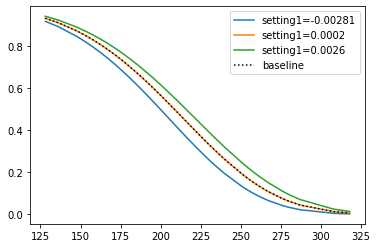

In [9]:
import numpy as np
aft.plot_partial_effects_on_outcome(['setting1'], values=max_event_censor_mix['setting1'].quantile([0.1, 0.5,0.9]).values)
plt.show()

可以看到，setting1的值增大时，生存时间提高。


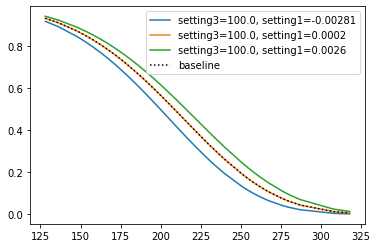

In [10]:
aft.plot_partial_effects_on_outcome(['setting3','setting1'], values=max_event_censor_mix[['setting3','setting1']].quantile([0.1, 0.5,0.9]).values)
plt.show()

我们也可以同时查看多个协变量的影响,也可以试试其他协变量。

In [11]:
aft1 = WeibullAFTFitter()
aft1.fit(df=max_event_censor_mix[['s11','cycle','observed']],duration_col='cycle',
event_col='observed')
aft1.summary

coef     exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                      
lambda_ s11        -0.780295  4.582708e-01  0.120694       -1.016851   
        Intercept  42.975986  4.615656e+18  5.815271       31.578265   
rho_    Intercept   1.730611  5.644100e+00  0.084924        1.564163   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ s11             -0.543739         3.617323e-01         5.805732e-01   
        Intercept       54.373707         5.179241e+13         4.113398e+23   
rho_    Intercept        1.897058         4.778675e+00         6.666255e+00   

                           z             p    -log2(p)  
param   covariate                                       
lambda_ s11        -6.465074  1.012492e-10   33.201370  
        Intercept   7.390195  1.466133e-13   42.633050  
rho_    Intercept  20.378404  2.599976e-92  304.238887

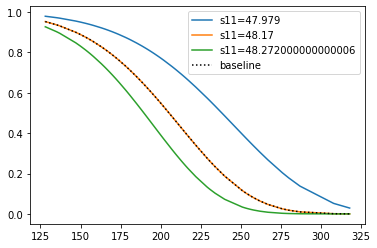

In [12]:
aft1.plot_partial_effects_on_outcome(['s11'], values=max_event_censor_mix[['s11']].quantile([0.1, 0.5,0.8]).values)
plt.show()

## 预测寿命（事件发生）

当我们训练好模型时，对于给定的协变量，会有不同的生存函数。

从生存函数中我们可以清晰的得到预期的寿命（事件发生的时间），这就是预测。

Lifeline提供了多种预测函数，比如预测中位数，预测百分位，预测生存函数，或者预测危险指数等。


In [13]:
max_event_censor_mix[['id','s11','cycle','observed']].iloc[-5:,:]

,id,s11,cycle,observed
17601,86.0,48.20,262,False
18832,92.0,48.02,318,False
19263,94.0,48.16,253,False
19521,95.0,47.76,253,False
19838,96.0,47.86,287,False


In [14]:
aft1.predict_median(max_event_censor_mix[['s11']].iloc[-5:,:])

17601    200.502620
18832    230.737435
19263    206.859354
19521    282.635231
19838    261.419821
dtype: float64

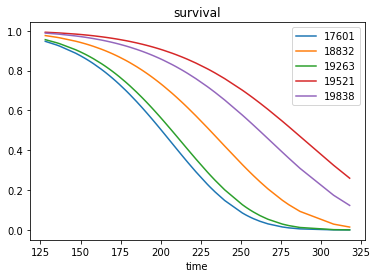

In [15]:
result= aft1.predict_survival_function(max_event_censor_mix[['s11']].iloc[-5:,:])
result.plot()
plt.xlabel('time')
plt.title('survival')
plt.show()

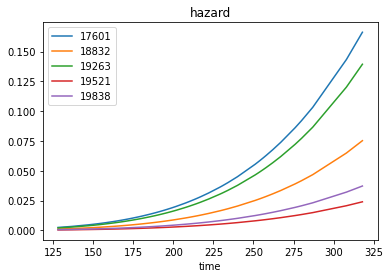

In [16]:
result= aft1.predict_hazard(max_event_censor_mix[['s11']].iloc[-5:,:])
result.plot()
plt.xlabel('time')
plt.title('hazard')
plt.show()